In [1]:
from model import UNet
from utils import *
from data import mask_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from glob import glob
import torch
import torch.nn as nn
sampleRate = 68.27

## Train - Val - Test sets

In [2]:
train_path = "train"
val_path = "validation"
test_path = "test"
train_files = glob(os.path.join(train_path, '*.npy'))
val_files = glob(os.path.join(val_path, '*.npy'))
test_files = glob(os.path.join(test_path, '*.npy'))

In [3]:
for file in train_files:
    if file in val_files:
        print(f"{file} in validation dataset.")
    elif file in test_files:
        print(f"{file} in test set.")
    else:
        pass

## Hyperparameters

In [4]:
N_sub = 32
batch_size = 56
hidden_layers = 12
learning_rate = 0.01
num_epochs = 10

## Datasets and DataLoaders (mine)

In [4]:
train_dataset = mask_dataset(data_path='train', f_min = 1, f_max = 10, N_sub=N_sub,sampleRate=sampleRate)
train_loader = DataLoader(train_dataset,batch_size = batch_size,drop_last=True,shuffle = True)

In [5]:
val_dataset = mask_dataset(data_path='validation', f_min = 1, f_max = 10, N_sub=N_sub, sampleRate=sampleRate)
val_loader = DataLoader(val_dataset,batch_size = batch_size,drop_last=True,shuffle = True)

In [6]:
test_dataset = mask_dataset(data_path='test', f_min = 1, f_max = 10, N_sub=N_sub, sampleRate=sampleRate)
test_loader = DataLoader(test_dataset,batch_size = batch_size,drop_last=True,shuffle = True)

In [7]:
# GPU
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device is {device}.')

model = UNet(input_bands=1, output_classes=1,hidden_channels=hidden_layers)
model.to(device)

# Mean Square Error 
criterion = nn.MSELoss()

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

NVIDIA GeForce RTX 2070
device is cuda:0.


In [12]:
epochs_losses_train = []
epochs_losses_val = []
for epoch in range(num_epochs):
    print(f"Starting epoch: #{epoch}")
    batch_losses = []
        ## TRAIN ##
    for eval_samples, mask in tqdm(test_loader):
        # apply mask
        sample = torch.unsqueeze(torch.tensor(eval_samples*mask).squeeze(), 1)
        # transfer to GPU
        eval_samples = eval_samples.to(device)
        sample = sample.to(device)
        optimizer.zero_grad()
        
        output = model(sample)
        loss = criterion(eval_samples.squeeze(),output.squeeze())
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epochs_losses_train.append(np.mean(batch_losses))
    model.eval()
    eval_losses = []
    with torch.no_grad():
        for eval_samples, mask in tqdm(val_loader):
            # apply mask
            sample = torch.unsqueeze(torch.tensor(np.ma.array(eval_samples,mask = np.logical_not(mask))).squeeze(), 1)
            # transfer to GPU
            eval_samples = eval_samples.to(device)
            sample = sample.to(device)
            output = model(sample)
            loss = criterion(eval_samples.squeeze(), sample.squeeze())
            eval_losses.append(loss.item())
    epochs_losses_val.append(np.mean(eval_losses))
    model.train()

Starting epoch: #0


  0%|          | 0/32 [00:00<?, ?it/s]C:\Users\nikos\AppData\Local\Temp/ipykernel_1260/511984774.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.unsqueeze(torch.tensor(eval_samples*mask).squeeze(), 1)
100%|██████████| 85/85 [00:10<00:00,  7.93it/s]


Starting epoch: #1


100%|██████████| 85/85 [00:10<00:00,  8.23it/s]


Starting epoch: #2


100%|██████████| 85/85 [00:10<00:00,  7.98it/s]


Starting epoch: #3


100%|██████████| 85/85 [00:10<00:00,  7.84it/s]


Starting epoch: #4


100%|██████████| 85/85 [00:10<00:00,  7.88it/s]


Starting epoch: #5


100%|██████████| 85/85 [00:11<00:00,  7.51it/s]


Starting epoch: #6


100%|██████████| 85/85 [00:12<00:00,  7.08it/s]


Starting epoch: #7


100%|██████████| 85/85 [00:11<00:00,  7.52it/s]


Starting epoch: #8


100%|██████████| 85/85 [00:11<00:00,  7.24it/s]


Starting epoch: #9


100%|██████████| 85/85 [00:11<00:00,  7.25it/s]


Text(0.5, 1.0, 'Validation MSE')

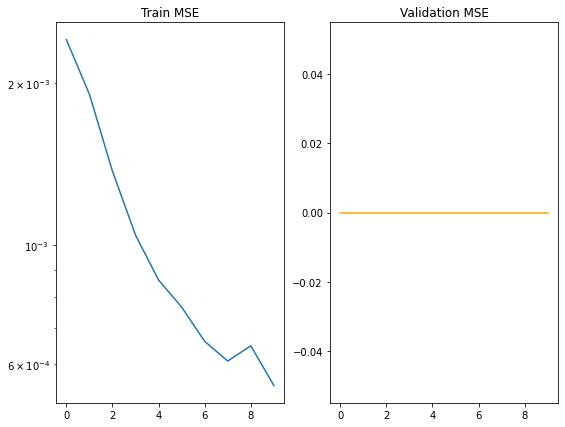

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (9,7))
ax1.plot(epochs_losses_train)
ax1.set_yscale("log")
ax1.set_title("Train MSE")
ax2.plot(epochs_losses_val,'orange')
ax2.set_title("Validation MSE")

In [10]:
torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                }, "C:\\Users\\nikos\\Desktop\\denoising\\model_inv.pth")


In [16]:
val_loader__ = DataLoader(val_dataset,batch_size = batch_size,shuffle = False)
model.eval()

UNet(
  (inc): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (down2): Down(
    (maxpool_conv): Sequenti

In [75]:
model = UNet(input_bands=1, output_classes=1,hidden_channels=hidden_layers)
state = torch.load('model.pth')
model.load_state_dict(state['model_state_dict'])
model.eval()
model.to(device)


UNet(
  (inc): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (down2): Down(
    (maxpool_conv): Sequenti

In [17]:
for eval_samples, masks in val_loader__:
    eval_samples = torch.unsqueeze(torch.tensor(eval_samples).squeeze(), 1).to(device)
    output = model(eval_samples)
    break

C:\Users\nikos\AppData\Local\Temp/ipykernel_1260/3215478376.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_samples = torch.unsqueeze(torch.tensor(eval_samples).squeeze(), 1).to(device)


In [32]:
masks.squeeze().shape

torch.Size([56, 32, 2048])

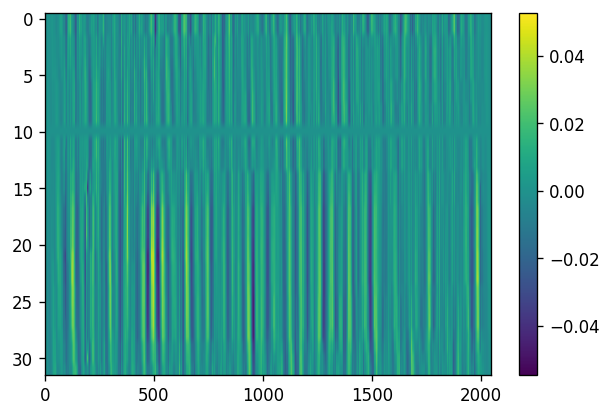

In [37]:
plt.figure(dpi=120)
plt.imshow((eval_samples.squeeze().cpu()*masks.squeeze().cpu())[10],aspect = 'auto')
plt.colorbar()

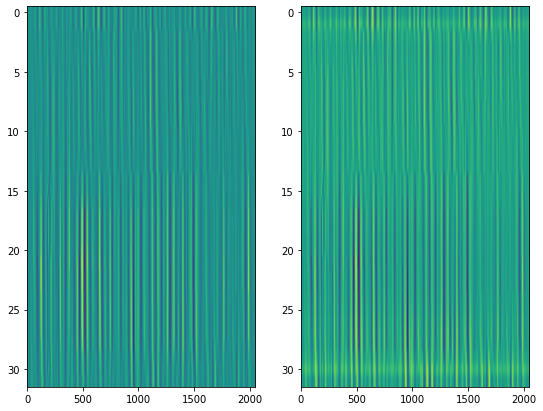

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (9,7))
ax1.imshow(eval_samples[0,0].cpu().detach().numpy(),aspect = 'auto')
ax2.imshow(output[0,0].cpu().detach().numpy(),aspect = 'auto')

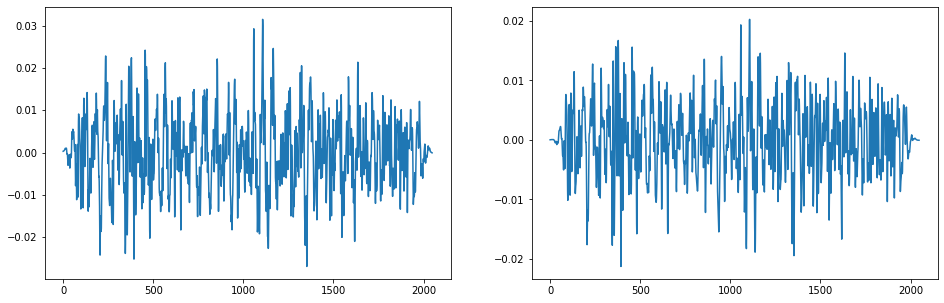

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.plot(eval_samples[10,0,10].cpu().detach().numpy())
ax2.plot(taper_filter(output[10,0,10].cpu().detach().numpy(),1,10,samp_DAS=sampleRate))